In [1]:
import numpy as np
import os

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator


pic_size=224
batchsize=128

# All images will be rescaled by 1./255
train_datagen =  ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/kaggle/input/face-expression-recognition-dataset/images/train',  # This is the source directory for training images
        target_size=(pic_size, pic_size), 
        color_mode='rgb',
        batch_size=batchsize,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        '/kaggle/input/face-expression-recognition-dataset/images/validation',  # This is the source directory for training images
        target_size=(pic_size, pic_size),
        color_mode='rgb',
        batch_size=batchsize,
        class_mode='categorical')


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [2]:
pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-8r1w9itq
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-8r1w9itq
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8315 sha256=453c88d8a6df8c2710a3dc3265fd1415d0b816179d97a0033ebd7439d584e80a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ffx3iy9o/wheels/62/cd/e0/3a2d2fe84d014324aed54d420cab52df65a774d9b296c63996
Successfully built keras-vggface
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install Keras-Applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# check version of keras_vggface
import keras_vggface
from keras_vggface.vggface import VGGFace
# print version
print(keras_vggface.__version__)

0.6


In [5]:
# example of creating a face embedding
from keras_vggface.vggface import VGGFace
# create a vggface2 model
vgg = VGGFace(model = 'vgg16',weights='vggface',include_top = False)
vgg_resnet = VGGFace(model = 'resnet50',weights='vggface',include_top = False)
vgg_senet50 = VGGFace(model = 'senet50',include_top = False)

104944616/104944616 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model

nb_class = 7
hidden_dim = 512

vgg_model = VGGFace(model = 'vgg16',weights='vggface',include_top=False, input_shape=(224, 224, 3))
last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dropout(0.2)(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)
vgg_model = Model(vgg_model.input, out)

In [6]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model

nb_class = 7
hidden_dim = 1048

vgg_model_1 = VGGFace(model = 'resnet50',weights='vggface',include_top=False, input_shape=(224, 224, 3))
last_layer = vgg_model_1.get_layer('avg_pool').output
x = Dropout(0.2)(last_layer)
x = Flatten(name='flatten')(x)
x = BatchNormalization()(x)
x = Dense(hidden_dim, activation='relu', name='classifier')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
out_1 = Dense(nb_class, activation='softmax', name='fc8')(x)
vgg_model_1 = Model(vgg_model_1.input, out_1)

In [32]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model

nb_class = 7
hidden_dim = 512

vgg_model_2 = VGGFace(model = 'senet50',weights='vggface',include_top=False, input_shape=(224, 224, 3))
last_layer = vgg_model_2.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = BatchNormalization()(x)
x = Dense(hidden_dim, activation='relu', name='classifier')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
out_2 = Dense(nb_class, activation='softmax', name='fc8')(x)
vgg_model_2 = Model(vgg_model_2.input, out_2)

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# ModelCheckpoint to save model in case of 
# interrupting the learning process
checkpoint = ModelCheckpoint("models/face_classifier_new.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

# EarlyStopping to find best model with a large number of epochs
earlystop = EarlyStopping(monitor='val_loss',
                          restore_best_weights=True,
                          patience=5,  # number of epochs with 
                                       # no improvement after which 
                                       # training will be stopped
                          verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
                                                  verbose=1)

callbacks = [earlystop, checkpoint,Reducing_LR]

In [ ]:
epochs = 50

vgg_model.compile(loss='categorical_crossentropy',
                        optimizer=Adam(learning_rate=0.001),
                        metrics=['accuracy'])

history = vgg_model.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator)

In [ ]:
epochs = 50

vgg_model.compile(loss='categorical_crossentropy',
                        optimizer=Adam(learning_rate=0.00001),
                        metrics=['accuracy'])

history = vgg_model.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator)

In [ ]:
epochs = 10

vgg_model_1.compile(loss='categorical_crossentropy',
                        optimizer=Adam(learning_rate=0.0001),
                        metrics=['accuracy'])

history = vgg_model_1.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator)

In [9]:
epochs = 30

vgg_model_1.compile(loss='categorical_crossentropy',
                        optimizer=Adam(learning_rate=0.00005),
                        metrics=['accuracy'])

history = vgg_model_1.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator)

Epoch 1/30


2023-05-19 01:58:54.710852: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


226/226 [==============================] - ETA: 0s - loss: 1.4723 - accuracy: 0.5115
Epoch 1: val_loss improved from inf to 2.02963, saving model to models/face_classifier_new.h5
226/226 [==============================] - 703s 3s/step - loss: 1.4723 - accuracy: 0.5115 - val_loss: 2.0296 - val_accuracy: 0.1612 - lr: 5.0000e-05
Epoch 2/30
226/226 [==============================] - ETA: 0s - loss: 1.0772 - accuracy: 0.6125
Epoch 2: val_loss improved from 2.02963 to 1.96766, saving model to models/face_classifier_new.h5
226/226 [==============================] - 485s 2s/step - loss: 1.0772 - accuracy: 0.6125 - val_loss: 1.9677 - val_accuracy: 0.1657 - lr: 5.0000e-05
Epoch 3/30
226/226 [==============================] - ETA: 0s - loss: 0.9585 - accuracy: 0.6488
Epoch 3: val_loss improved from 1.96766 to 1.25703, saving model to models/face_classifier_new.h5
226/226 [==============================] - 481s 2s/step - loss: 0.9585 - accuracy: 0.6488 - val_loss: 1.2570 - val_accuracy: 0.5204 - l

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# ModelCheckpoint to save model in case of 
# interrupting the learning process
checkpoint = ModelCheckpoint("models/face_classifier_new_2.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

# EarlyStopping to find best model with a large number of epochs
earlystop = EarlyStopping(monitor='val_loss',
                          restore_best_weights=True,
                          patience=5,  # number of epochs with 
                                       # no improvement after which 
                                       # training will be stopped
                          verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
                                                  verbose=1)

callbacks = [earlystop, checkpoint,Reducing_LR]

In [ ]:
epochs = 50

vgg_model_2.compile(loss='categorical_crossentropy',
                        optimizer=Adam(learning_rate=0.00001),
                        metrics=['accuracy'])

history = vgg_model_2.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator)

In [ ]:
from tensorflow import keras
model = keras.models.load_model('models/face_classifier_new.h5')

In [ ]:
!tensorflowjs_converter --input_format=keras {"models/face_classifier_new.h5"} ./

# Load Model


In [ ]:
from keras.models import load_model
model_load=load_model('/kaggle/input/aaaaaaaaaaaaaaaaa/face_classifier_new.h5')

In [17]:
from tensorflow import keras
model_load = keras.models.load_model('models/face_classifier_new.h5')

In [11]:
# Common imports
import numpy as np

# TensorFlow imports
# may differs from version to versions
import tensorflow as tf
from tensorflow import keras

# OpenCV
import cv2

In [12]:
def show_image(image):
    plt.figure(figsize=(224,224))
    #Before showing image, bgr color order transformed to rgb order
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [13]:
 # opencv object that will detect faces for us
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [18]:
def get_extended_image(img, x, y, w, h, k=0.1):
    '''
    Function, that return cropped image from 'img'
    If k=0 returns image, cropped from (x, y) (top left) to (x+w, y+h) (bottom right)
    If k!=0 returns image, cropped from (x-k*w, y-k*h) to (x+k*w, y+(1+k)*h)
    After getting the desired image resize it to 250x250.
    And converts to tensor with shape (1, 250, 250, 3)

    Parameters:
        img (array-like, 2D): The original image
        x (int): x coordinate of the upper-left corner
        y (int): y coordinate of the upper-left corner
        w (int): Width of the desired image
        h (int): Height of the desired image
        k (float): The coefficient of expansion of the image

    Returns:
        image (tensor with shape (1, 224, 224, 3))
    '''

    # The next code block checks that coordinates will be non-negative
    # (in case if desired image is located in top left corner)
    if x - k*w > 0:
        start_x = int(x - k*w)
    else:
        start_x = x
    if y - k*h > 0:
        start_y = int(y - k*h)
    else:
        start_y = y

    end_x = int(x + (1 + k)*w)
    end_y = int(y + (1 + k)*h)

    face_image = img[start_y:end_y,
                     start_x:end_x]
    return face_image

1/1 [==============================] - 0s 31ms/step
happy
0.9689407


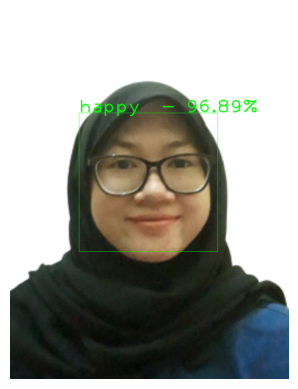

In [25]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from skimage import transform
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
path_img="/kaggle/input/aaaaaa/Aulia.png"


class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

image=cv2.imread(path_img)
color = (0, 255, 0)
pic_size = 224
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray,
                                      scaleFactor=1.3, 
                                      minNeighbors=5,
                                      flags=cv2.CASCADE_SCALE_IMAGE)
for (x, y, w, h) in faces:
    # for each face on the image detected by OpenCV
    # get extended image of this face
    face_image = get_extended_image(image, x, y, w, h, 0.5)
    face_image = np.array(face_image).astype('float32')/255
    face_image = transform.resize(face_image, (pic_size, pic_size, 3))
    face_image = np.expand_dims(face_image, axis=0)
    result = model_load.predict(face_image)
    prediction = class_names[np.array(result[0]).argmax(axis=0)]  # predicted class
    confidence = np.array(result[0]).max(axis=0)  # degree of confidence
    print(prediction)
    print(confidence)
    cv2.rectangle(image,(x, y),  # start_point
                  (x+w, y+h),  # end_point
                  color,
                  2)  # thickness in px
    cv2.putText(image,
                # text to put
                "{:6} - {:.2f}%".format(prediction, confidence*100),
                (x, y),
                cv2.FONT_HERSHEY_PLAIN,  # font
                10,  # fontScale
                color,
                10)  # thickness in px


plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()